### Application: Model Time-Series Data by using Neural Network and Neural ODEs

Neural Ordinary Differential Equations also can be used to model continuous-time dynamics, making them quite suitable for time-series data. In this part we'll explore the implementation for a set of time-series data by Neural Networks and Neural ODEs. We will expect a higher accuracy approximation by using Neural ODE method.

Firstly, we import the necessary packages and some functions like NeuralODE(), Flux.trainable(), which will be attached in the Appendix file. These functions are commonly used for application of Neural ODEs.

In [1]:
using DifferentialEquations, Flux, Zygote

# Extend Zygote to work with Neural ODE
function Zygote._zero(xs::AbstractArray{<:AbstractArray}, T=Any)
    return [Zygote._zero(x) for x in xs]
end

### ============================================================================
### Neural ODE Layer Struct and Constructor
### ============================================================================

# A Neural ODE consists of a function f(z, θ, t) that models z's derivative, and
# the parameters `θ` to be optimized, and the time span of the integral.
# Additionally, we also store the ODE solver's solution, since it is useful for
# the backward pass via the adjoint method.
struct NeuralODE{F, P, T, S}
    f::F     # derivative model
    θ::P     # vector of parameters
    tspan::T # time span [t0, t1]
    sol::S   # vector of ODE solution
end

# We store the ODE solver's solution in a vector instead of directly to make the
# `NeuralODE` struct immutable for better performace. At initialization, this is
# simply an empty vector.
function NeuralODE(f, θ, tspan)
    return NeuralODE(f, θ, tspan, DiffEqBase.AbstractODESolution[])
end

### ============================================================================
### Flux compatibility
### ============================================================================

# Using the macro `Flux.@functor` allows the machine learning library Flux to
# mix our `NeuralODE` layer in any model.
Flux.@functor NeuralODE

# We also specify the parameters `θ` to be optimized with `Flux.trainable`. We
# only update `θ` by default, but we can also optimize the time span.
Flux.trainable(node::NeuralODE) = (node.θ,)

### ============================================================================
### Forward pass
### ============================================================================

# The forward pass computes the integration with the ODE solver. The forward
# pass returns an array of the solution at each timestep.
function (node::NeuralODE)(z_t0; alg=Tsit5(), kwargs...)
    f, θ, t0, t1, sol = node.f, node.θ, node.tspan[1], node.tspan[2], node.sol
    return forward!(z_t0, θ, t0, t1; f=f, sol=sol, alg=alg, kwargs...)
end

# Integrate from `t0` to `t1` to calculate `z` at `t1`, also returns `z` at
# each timestep in a vector.
function forward!(z_t0, θ, t0, t1; f, sol, alg, kwargs...)
    # Define and solve ODE problem
    function dzdt(dz, z, θ, t)
        dz .= f(z, θ, t)
    end
    problem = ODEProblem(dzdt, z_t0, (t0, t1), θ)
    solution = solve(problem, alg; kwargs...)

    # Store the solution for the backward pass
    empty!(sol)
    push!(sol, solution)

    # Return an array of `z` evaluated at each timestep
    return solution.u
end

### ============================================================================
### Backward pass
### ============================================================================

# Since back-propagating through the ODE solver is complex, we define a custom
# backward pass for the Neural ODE via the adjoint method. Flux relies on the
# Zygote library to calculate gradients, and we can define our custom gradient
# via `Zygote.@adjoint`.
Zygote.@adjoint function forward!(z_t0, θ, t0, t1; f, sol, alg, kwargs...)
    # Forward pass
    zs = forward!(z_t0, θ, t0, t1; f=f, sol=sol, alg=alg, kwargs...)

    # Return the forward pass and how to calculate the gradients of the loss wrt
    # `z_t0` and `θ` from the gradient of the loss wrt `z` at each timestep.
    return zs, ∂L∂zs -> backward(∂L∂zs, θ; f=f, sol=sol[1], alg=alg)
end

# Compute the gradients of the loss wrt to `θ`.
function backward(∂L∂zs, θ; f, sol, alg)
    # Calculate the partial derivatives from each relevant `∂L∂z`   
    # Function to handle iszero and nothing
    function iszero_or_nothing(x)
        if x === nothing
            return true  # Treat `nothing` as zero
        else
            return iszero(x)
        end
    end
    # Ensure set_zero does not introduce Nothing values
    
    
    # Handle potential Nothing values in the iszero check
    idxs = .!(iszero_or_nothing.(∂L∂zs)) |> collect
    
    t0 = sol.t[1]
    t1s = sol.t[idxs]
    ∂s = _backward.(∂L∂zs[idxs], Ref(θ), t0, t1s; f=f, sol=sol, alg=alg)
    
    # Aggregate all partial derivatives
    ∂L∂t_N = ∂s[end][end]
    ∇ = map(+, [∂[1:3] for ∂ in ∂s]...)
    return (∇..., ∂L∂t_N)
end

# Given the gradient of the loss wrt `z` at time `t1`, compute the partial
# derivatives wrt `z_t0` and `θ` via the adjoint method.
function _backward(∂L∂z_t1, θ, t0, t1; f, sol, alg)
    # Derivative of the loss wrt `t1`
    ∂L∂t1 = ∂L∂z_t1[:]' * f(sol[end], θ, t1)[:]

    # We define the initial augmented state, which consists of the gradients of
    # the loss wrt to `z_t1` and `θ` and `t1`. `ArrayPartition` from the
    # DifferentialEquations library allows us to combine arrays with different
    # dimensions for a single call to the ODE solver.
    s_t1 = ArrayPartition(∂L∂z_t1, zero(θ), [-∂L∂t1])

    # Define the dynamics of the augmented state
    function dsdt(ds, s, θ, t)
        # Compute the Jacobian matrices of `f` wrt `z`, `θ`, and `t`
        _, back = Zygote.pullback(f, sol(t), θ, t)

        # Adjoint dynamics
        d = back(-s.x[1])

        # Zygote returns `nothing` as a strong zero if the function is not
        # dependent on the variable, so we convert to zero for computation
        function get_derivative(Δ, x)
            if Δ == nothing    
                return zero(x)
            else
                return Δ
            end
        end
        
        Δs = get_derivative.(d, ds.x[:])

        # Return the derivatives
        for i in 1:3
            ds.x[i] .= Δs[i]
        end
    end

    # Solve ODE backwards
    problem = ODEProblem(dsdt, s_t1, (t1, t0), θ)
    solution = solve(problem, alg)
    s_t0 = solution[end]

    # Return gradients
    return (s_t0.x[1], s_t0.x[2], -s_t0.x[3][1], ∂L∂t1)
end

_backward (generic function with 1 method)

Here we consider a synthetic dataset for simplicity, we'll use  𝑠𝑖𝑛  function to generate time-series data. Note that we add perturbations to the  𝑠𝑖𝑛  function can better simulate real-world scenarios, like the stocks.

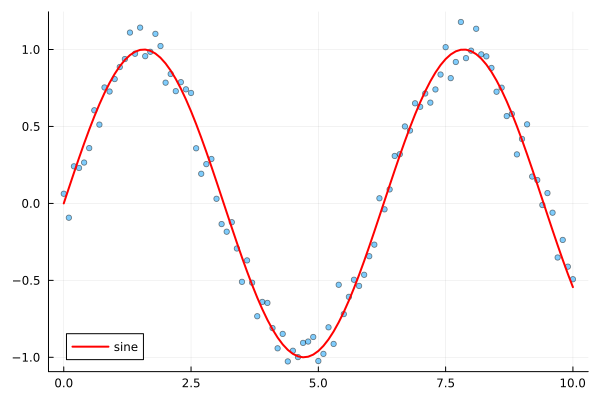

In [2]:
using Plots

function generate_data()
    t = 0:0.1:10  # time points with fixed interval
    y = sin.(t) + 0.1 * randn(length(t))  # sin wave with noise
    return t, y
end

# Generate the traning data
X, Y = generate_data()

# Visualization of sine function and training data
xgrid = 0:0.1:10
function plot_data()
	scatter(X, Y, label = :none, ms = 3, alpha = 0.5)    # training data
	plot!(xgrid, sin.(xgrid), label = "sine", lw = 2, c = :red)    # sine function
end
pl1 = plot_data()

Next, we want to define a neural network to represent the dynamics of the system, and use  𝑡𝑎𝑛ℎ  as the acivation function. Meanwhile, let the parameters be optimised.

In [3]:
# Define neural network model
nn_model = Chain(Dense(1, 8, tanh), Dense(8, 1))

# Parameters to be optimized
nn_params = Flux.params(nn_model)

Params([Float32[0.4017059; 0.40475976; … ; -0.2581919; 0.24419315;;], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.61517507 0.39430627 … 0.21487206 0.4301326], Float32[0.0]])

Then we define a loss function.

In [4]:
# Sum of squared error as loss function
nn_loss() = sum(abs2, nn_model(reshape(X, 1, :)) - Y')

nn_loss (generic function with 1 method)

Now, we want to set up the training data iterator, then set up the optimizor, which initializes an ADAM optimizer. And follow by storing loss values; then uses "Flux.train!" function to train the neural network. Finally we plot the Loss Values. 

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 8, tanh)  # 16 parameters
│   summary(x) = "1×101 reshape(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, 1, 101) with eltype Float64"
└ @ Flux ~/.julia/packages/Flux/Wz6D4/src/layers/stateless.jl:60


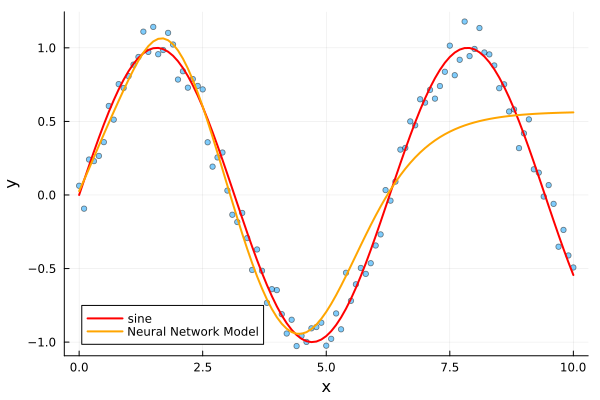

In [6]:
# Set up to run for 100 epochs
nn_data = Iterators.repeated((), 100)

# Optimizer
nn_opt = ADAM(0.1)

# Store loss each epoch for visualization
nn_losses = Float32[]
nn_cb = () -> begin
    push!(nn_losses, nn_loss())
end

# Training loop
Flux.train!(nn_loss, nn_params, nn_data, nn_opt, cb=nn_cb)
pl2 = plot(1:100, nn_losses, label="Neural Network Model Loss", xlabel='x',ylabel='y',c=:orange)

# Network Visualization
plot!(pl1, xgrid, nn_model(xgrid')', c=:orange, lw=2, 
    xlabel="x", ylabel="y", label="Neural Network Model")

Then, we want to create a augmented Neural ODE and make the parameters to be trainable. The reason we augment the state space is that we can increase the model's capacity to capture complex dynamics and dependencies in the data set, so which lead to enhance the accuracy and performance in identifying trends within the time-series data.

In [8]:
# Derivative model
model = Chain(Dense(6, 8, tanh), Dense(8, 6))
θ, re = Flux.destructure(model)
dzdt(z, θ, t) = re(θ)(z)

# Define Augmented Neural ODE
anode_model = NeuralODE(dzdt, θ, [0.0f0, 10.0f0])

# Parameters to be optimized, including time span
Flux.trainable(node::NeuralODE) = (node.θ, node.tspan)
anode_params = Flux.params(anode_model)

# Input augmentation
aug_X = hcat(X, zeros(eltype(X), length(X), 5)) |> transpose

6×101 transpose(::Matrix{Float64}) with eltype Float64:
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  …  9.4  9.5  9.6  9.7  9.8  9.9  10.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0   0.0

As we have done before, we define the loss function for the augmented neural ODE model, then the training process is set up to run for 100 epochs using an iterator. Follows by setting up an ADAM optimizer with a learning rate of 0.01 is initialized. Losses are tracked in an array for visualization, and a callback function adds the current loss to the array after each epoch. The training loop is executed with Flux's train! function, using the loss function, parameters, data iterator, optimizer, and the callback function.

In [9]:
# Sum of squared error as loss function
anode_loss() = sum(abs2, anode_model(aug_X)[end][1, :] - Y)

# Set up to run for 100 epochs
anode_data = Iterators.repeated((), 100)

# Optimizer
anode_opt = ADAM(0.01)

# Store losses for visualization
anode_losses = Float32[]
anode_cb = () -> begin
    push!(anode_losses, anode_loss())
end

# Training loop
Flux.train!(anode_loss, anode_params, anode_data, anode_opt, cb=anode_cb)

Now we plot the graphs together so the we can compare the effects of both methods througout visualzation.

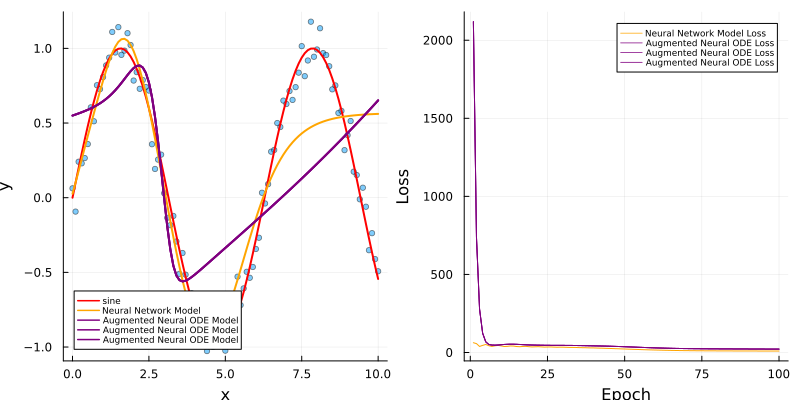

In [13]:
# Plot losses versus epochs
plot!(pl2, 1:100, anode_losses, label="Augmented Neural ODE Loss",
    xlabel="Epoch", ylabel="Loss", c=:purple)

# Augmented Neural ODE visualization
aug_xgrid = hcat(xgrid, zeros(eltype(xgrid), length(xgrid), 5)) |> transpose
plot!(pl1, xgrid, anode_model(aug_xgrid)[end][1, :], lw=2, c=:purple,
xlabel="x", ylabel="y", label="Augmented Neural ODE Model")    

# Plot all visualizations
plot(pl1, pl2, legendfontsize=6, size=(800, 400))

From the results we have seen that the Neural ODE provides a better approximation!